#### Подключение библиотек и скриптов

In [853]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [854]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [1023]:
DATASET_PATH_TRAIN = './train.csv'
DATASET_PATH_TEST = './test.csv'

PREPARED_DATASET_PATH_TRAIN = './prepared_train.csv'
PREDICTIONS_PATH = './ASvincov_predictions.csv'

## Загрузка данных

In [856]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [857]:
df_train = pd.read_csv(DATASET_PATH_TRAIN, sep=',')
df_train = reduce_mem_usage(df_train)
df_train.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


#### EDA

In [858]:
df_train.shape

(10000, 20)

In [859]:
# 10000 объектов, 20 признаков

In [860]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [861]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [862]:
# есть пропущенные значения

**Описание датасета**
* **DistrictId** - ID локации       
* **Rooms** - кол-во комнат          
* **Square** - общая площадь   
* **LifeSquare** - жилая площадь    
* **KitchenSquare** - площадь кухни 
* **Floor** - этаж            
* **HouseFloor** - этажность дома  
* **HouseYear** - год постройки дома    
* **Ecology_1** - экологический показатель 1     
* **Ecology_2** - экологический показатель 2     
* **Ecology_3** - экологический показатель 3     
* **Social_1** - социальный показатель 1      
* **Social_2** - социальный показатель 2      
* **Social_3** - социальный показатель 3      
* **Healthcare_1** - показатель доступности здравохранения 1   
* **Helthcare_2** - показатель доступности здравохранения 2   
* **Shops_1** - показатель доступности магазинов 1       
* **Shops_2** - показатель доступности магазинов 2
* **Price** - цена (целевой показатель)         

#### Обработка пропусков

In [863]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [864]:
medians = df_train[['LifeSquare', 'Healthcare_1']].median()

In [865]:
df_train[['LifeSquare', 'Healthcare_1']] = \
        df_train[['LifeSquare', 'Healthcare_1']].fillna(medians)

In [866]:
df_train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

#### Удаление индекса из датасета

In [867]:
df_train.drop('Id', axis = 1, inplace=True)

#### Анализ количественных признаков 

#### Распределение целевого признака

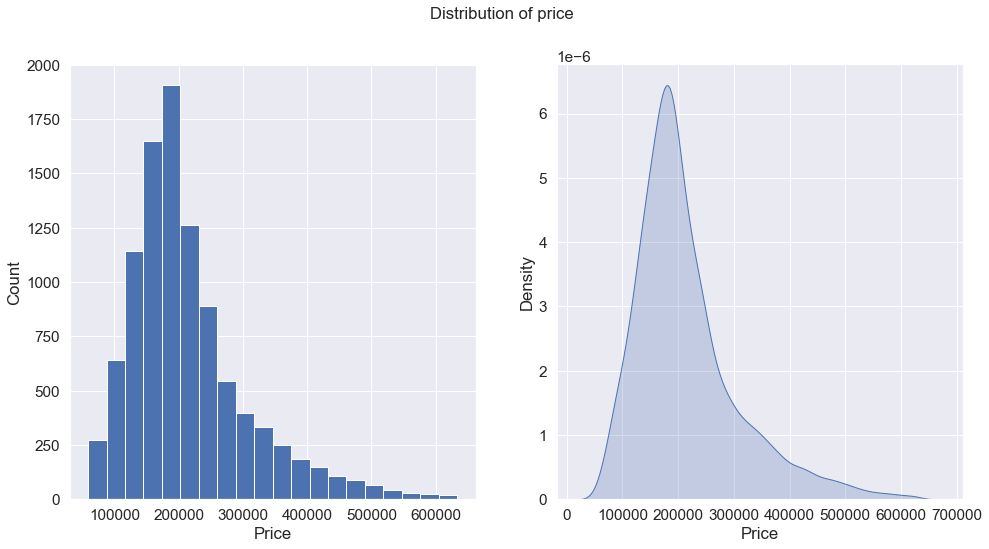

In [868]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Price'].hist(density=False, bins=20)
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

#### Анализ объясняющих переменных

In [869]:
df_train_num_features = df_train.select_dtypes(include=['float32', 'float16', 'int32', 'int16', 'int8'])

In [870]:
df_train_num_features.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,184966.937500
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.437500
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.906250
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.234375
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531250


In [871]:
df_train_num_features.drop(['Price'], axis=1, inplace=True)

In [872]:
df_train_num_features.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315712,36.266048,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358887,1.319500,4.231300
std,43.587592,0.839523,21.058718,76.609917,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,746.645447,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774879,25.527400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900627,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


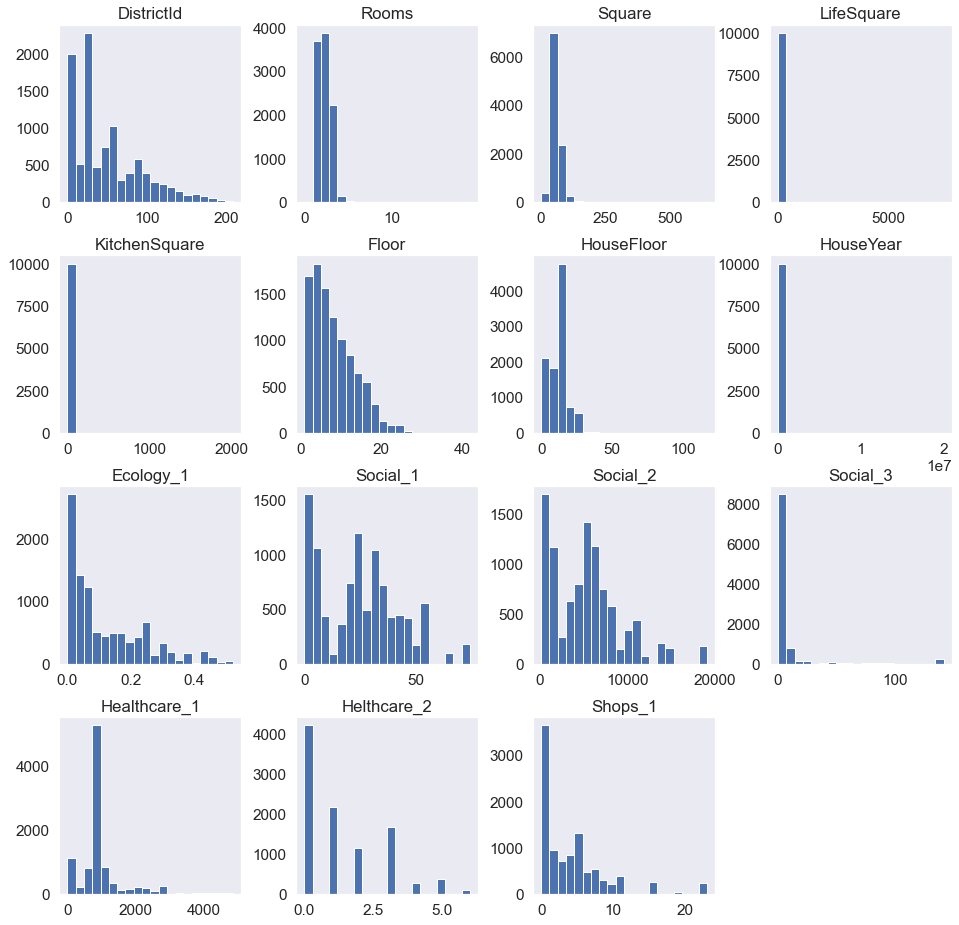

In [873]:
df_train_num_features.hist(figsize=(16,16), bins=20, grid=False);

#### Обработка выбросов

In [874]:
df_train_num_features.loc[df_train_num_features['HouseYear'] > 2023]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
1497,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,30,6141,10,262.0,3,6
4189,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,25,4756,16,2857.0,5,8


In [875]:
df_train_num_features.loc[df_train_num_features['HouseYear'] == 20052011] = 2005

In [876]:
df_train_num_features.loc[df_train_num_features['HouseYear'] > 2023] = df_train['HouseYear'].median()

In [877]:
df_train_num_features['HouseOld'] = 2023 - df_train_num_features['HouseYear']

In [878]:
df_train_num_features['HouseOld'].describe()

count    10000.000000
mean        38.133400
std         18.410913
min          3.000000
25%         22.000000
50%         46.000000
75%         49.000000
max        113.000000
Name: HouseOld, dtype: float64

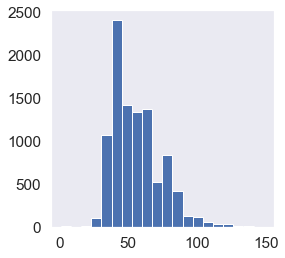

In [879]:
df_train.loc[df_train['Square'] < 150, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [880]:
df_train.loc[df_train['Square'] > 150, 'Square'] = df_train['Square'].median()

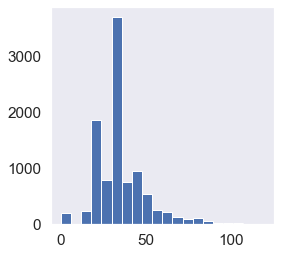

In [881]:
df_train.loc[df_train['LifeSquare'] < 120, 'LifeSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [882]:
df_train.loc[df_train['LifeSquare'] > 120, 'LifeSquare'] = df_train['LifeSquare'].median()

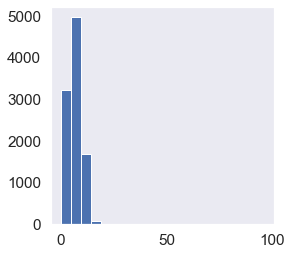

In [883]:
df_train.loc[df_train['KitchenSquare'] < 100, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [884]:
df_train.loc[df_train['KitchenSquare'] > 25, 'KitchenSquare'] = df_train['KitchenSquare'].median()

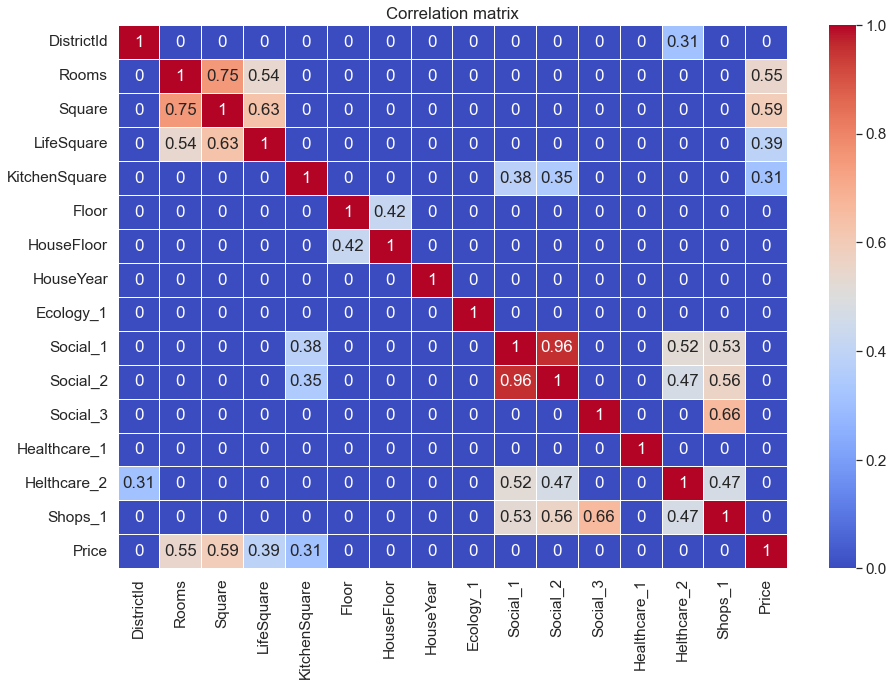

In [885]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [886]:
# Высокая мультиколлинеарность между объясняющими переменными: Social1 и Social2. Во избежание переобучаемости модели исключим
# второй фактор.

#### Анализ категориальных признаков

In [887]:
df_train_obj_features = df_train.select_dtypes(include='category')
df_train_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [888]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [889]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [890]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [891]:
# Наблюдается неравномерное распределение значений признаков. Исключим из модели

#### Разбиение на train / valid 

In [892]:
X = df_train_num_features
y = df_train['Price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)
X_train.index

Int64Index([8511, 1449, 2965, 9497, 5488, 8809, 3560, 8709, 3502, 7831,
            ...
            4376,  802, 5646, 7906, 4149,  350,   79, 8039, 6936, 5640],
           dtype='int64', length=6700)

#### Оставим признаки, которые необходимы для модели

In [893]:
X_train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'HouseOld']

In [894]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Healthcare_1', 'Shops_1', 'HouseOld']

target_name = 'Price'

In [895]:
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]

X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Healthcare_1,Shops_1,HouseOld
8511,5.0,198.930176,123.139862,10.0,1,0.014073,2,900.0,0,12
1449,2.0,61.735729,62.898666,0.0,16,0.243205,5,540.0,0,46
2965,2.0,65.712166,32.781261,1.0,9,0.161532,25,30.0,4,46
9497,2.0,51.192204,32.620075,8.0,1,0.090799,74,900.0,15,35
5488,3.0,76.745483,49.723179,9.0,9,0.000070,46,240.0,16,38


#### Стандартизация признаков

In [896]:
X_train.dtypes

Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
Ecology_1        float32
Social_1            int8
Healthcare_1     float32
Shops_1             int8
HouseOld           int32
dtype: object

In [897]:
feature_names_for_stand = X_train.select_dtypes(include=['float32','int8', 'int32']).columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'Ecology_1',
 'Social_1',
 'Healthcare_1',
 'Shops_1',
 'HouseOld']

In [898]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Healthcare_1,Shops_1,HouseOld
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,2.480746,56.745411,35.971397,7.046418,8.514925,0.713540,24.563731,1026.140137,4.194925,38.152836
std,34.373890,39.888149,38.683945,48.808075,5.344939,34.395988,17.616987,747.051636,4.939089,18.469784
min,0.000000,1.136859,0.370619,0.000000,-71.000000,0.000000,-71.000000,30.000000,-71.000000,3.000000
25%,1.000000,41.733551,25.400899,1.000000,4.000000,0.019509,6.000000,830.000000,1.000000,22.000000
50%,2.000000,52.256666,32.781261,6.000000,7.000000,0.075779,25.000000,900.000000,3.000000,46.000000
75%,2.000000,65.821829,41.185266,9.000000,12.000000,0.195781,36.000000,990.000000,5.000000,49.000000
max,2005.000000,2005.000000,2005.000000,2014.000000,37.000000,2005.000000,74.000000,4849.000000,23.000000,113.000000


In [902]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])

In [903]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Healthcare_1,Shops_1,HouseOld
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,2.480746,56.745411,35.971397,7.046418,8.514925,0.713540,24.563731,1026.140137,4.194925,38.152836
std,34.373890,39.888149,38.683945,48.808075,5.344939,34.395988,17.616987,747.051636,4.939089,18.469784
min,0.000000,1.136859,0.370619,0.000000,-71.000000,0.000000,-71.000000,30.000000,-71.000000,3.000000
25%,1.000000,41.733551,25.400899,1.000000,4.000000,0.019509,6.000000,830.000000,1.000000,22.000000
50%,2.000000,52.256666,32.781261,6.000000,7.000000,0.075779,25.000000,900.000000,3.000000,46.000000
75%,2.000000,65.821829,41.185266,9.000000,12.000000,0.195781,36.000000,990.000000,5.000000,49.000000
max,2005.000000,2005.000000,2005.000000,2014.000000,37.000000,2005.000000,74.000000,4849.000000,23.000000,113.000000


In [904]:
scaler.mean_

array([2.48074627e+00, 5.67455356e+01, 3.59713955e+01, 7.04641791e+00,
       8.51492537e+00, 7.13527925e-01, 2.45637313e+01, 1.02614015e+03,
       4.19492537e+00, 3.81528358e+01])

In [905]:
scaler.var_

array([1.18145530e+03, 1.59082784e+03, 1.49625100e+03, 2.38177770e+03,
       2.85641056e+01, 1.18288540e+03, 3.10311908e+02, 5.58016763e+05,
       2.43909593e+01, 3.41082014e+02])

In [906]:
stand_features_train

array([[ 0.07329313,  3.56484862,  2.25349801, ..., -0.16886114,
        -0.84939519, -1.41608518],
       [-0.01398644,  0.12511397,  0.69612962, ..., -0.6507855 ,
        -0.84939519,  0.42489667],
       [-0.01398644,  0.22481106, -0.08247203, ..., -1.33351167,
        -0.0394688 ,  0.42489667],
       ...,
       [ 0.01510675,  0.16060785,  0.29164536, ..., -1.0229382 ,
         0.36549439,  1.1288015 ],
       [-0.04307963, -0.27242004, -0.40365439, ...,  2.13366635,
        -0.2419504 , -0.27900815],
       [-0.04307963, -0.31757902, -0.45432377, ..., -0.51022423,
         0.36549439, -0.00827553]])

In [907]:
X_train[feature_names_for_stand] = stand_features_train
X_valid[feature_names_for_stand] = stand_features_valid

#### Сохранение обработанного датасета

In [908]:
X_train.to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, encoding='utf-8', sep=';')

#### Построение модели

In [909]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.688


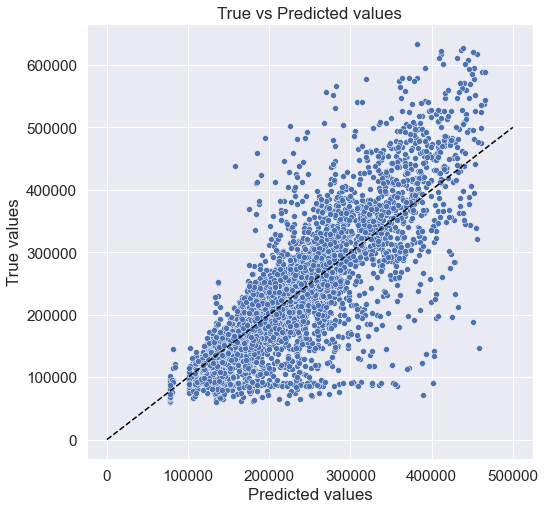

In [910]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20,  
                                 min_samples_leaf=30, 
                                 random_state=42, 
                                 n_estimators=100  
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.647


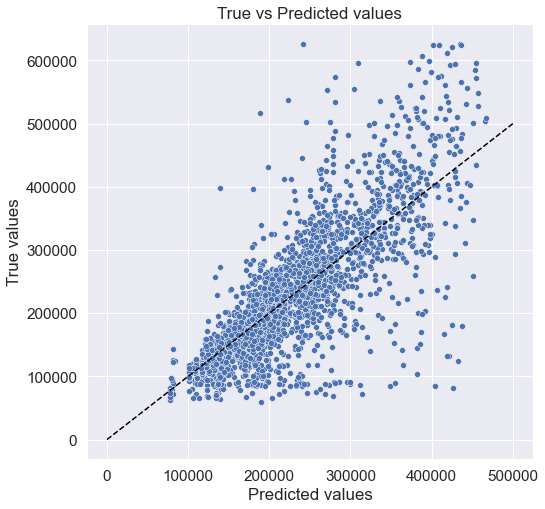

In [911]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

### Кросс-валидация

In [818]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[10, 15, 20, 30]}

gs = GridSearchCV(rf_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: total: 1.56 s
Wall time: 1min 6s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(criterion='mse', max_depth=20,
                                             min_samples_leaf=30,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 30],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [819]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.648993,0.008094,0.012051,0.002572,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.597027,0.639138,0.673238,0.585754,0.626568,0.624345,0.031144,16
1,1.295182,0.016582,0.022717,0.002291,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.597098,0.640519,0.676035,0.586119,0.626770,0.625308,0.032057,13


In [820]:
gs.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [821]:
gs.best_score_

0.6276459727708721

#### Оценка важности признаков

In [822]:
rf_model.feature_importances_

array([0.10796401, 0.50836887, 0.00967862, 0.01332586, 0.0137085 ,
       0.0291716 , 0.24853606, 0.02672604, 0.01884897, 0.02367149])

In [823]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [824]:
feature_importances

,feature_name,importance
1,Square,0.508369
6,Social_1,0.248536
0,Rooms,0.107964
5,Ecology_1,0.029172
7,Healthcare_1,0.026726
9,HouseOld,0.023671
8,Shops_1,0.018849
4,Floor,0.013709
3,KitchenSquare,0.013326
2,LifeSquare,0.009679


#### Загрузка и обработка данных тестового датасета

In [978]:
df_test = pd.read_csv(DATASET_PATH_TEST, sep=',')
df_test = reduce_mem_usage(df_test)
df_test.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [979]:
medians = df_test[['LifeSquare', 'Healthcare_1']].median()
df_test[['LifeSquare', 'Healthcare_1']] = \
        df_test[['LifeSquare', 'Healthcare_1']].fillna(medians)

In [980]:
df_test.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [981]:
df_test.drop('Id', axis = 1, inplace=True)

In [982]:
df_test_num_features = df_test.select_dtypes(include=['float32', 'float16', 'int32', 'int16', 'int8'])

In [983]:
df_test_num_features['HouseOld'] = 2023 - df_test_num_features['HouseYear']

In [984]:
df_test.loc[df_train['Square'] > 150, 'Square'] = df_test['Square'].median()
df_test.loc[df_train['LifeSquare'] > 120, 'LifeSquare'] = df_test['LifeSquare'].median()
df_test.loc[df_train['KitchenSquare'] > 25, 'KitchenSquare'] = df_test['KitchenSquare'].median()

In [985]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Healthcare_1', 'Shops_1', 'HouseOld']

In [990]:
X_test = df_test_num_features[feature_names]
X_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Healthcare_1,Shops_1,HouseOld
0,2.0,49.882645,33.432781,6.0,6,0.310199,11,900.0,0,51
1,2.0,69.263184,32.925087,1.0,6,0.075779,6,900.0,2,46
2,1.0,13.597818,15.948246,12.0,2,0.000000,30,4702.0,5,114
3,2.0,73.046608,51.940842,9.0,22,0.101872,23,900.0,3,16
4,1.0,47.527111,43.387569,1.0,17,0.072158,2,900.0,0,6


Стандартизация признаков

In [991]:
stand_features_test = scaler.transform(X_test[feature_names])

Построение модели

In [992]:
y_test_preds = rf_model.predict(X_test)

In [1017]:
df_test['Price'] = y_test_preds

In [1032]:
df_test.to_csv(PREDICTIONS_PATH, columns = ['Price'], index=False)